In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [2]:
seq_len = 96
predict_len = 96
hidden_size = 50
output_size = 1
num_layers = 5
batch_size = 256
lr = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#首先制作数据集
def get_data(csv,item,seq_len,predict_len):
    full_data = pd.read_csv(csv)
    data = full_data[item]
    
    data = np.array(data)
    
    x = []
    y = []
    
    for i in range(data.shape[0]-seq_len-predict_len):
        x_one = data[i:i+seq_len]
        y_one = data[i+seq_len:i+seq_len+predict_len]
        
        x_one = np.array(x_one)
        y_one = np.array(y_one)
        
        
        x.append(x_one)
        y.append(y_one)
        
    x = np.array(x)
    max_value = np.max(x)
    min_value = np.min(x)
    x = (x-min_value) / (max_value-min_value)
    y = np.array(y)
    
    
    train = int(x.shape[0]*0.8)
    valid = int(x.shape[0]*0.1)
    x_train,x_valid,x_test = x[:train],x[train:train+valid],x[train+valid:]
    y_train,y_valid,x_test = y[:train],y[train:train+valid],y[train+valid:]
    
    return x_train,x_valid,x_test,y_train,y_valid,x_test

In [4]:
x_train,x_valid,x_test,y_train,y_valid,y_test = get_data('./data/stations_data/df_station_1001.csv','PM25_Concentration',seq_len,predict_len)

In [5]:
class Mydataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        x = self.x[idx]
        if self.transform:
            x = self.transform(x)
        return x,self.y[idx]

In [6]:
train_dataset = Mydataset(x_train,y_train)
valid_dataset = Mydataset(x_valid,y_valid)
test_dataset = Mydataset(x_test,y_test)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [7]:
for i,(x,y) in enumerate(test_loader):
    print(x.shape)
    print(y.shape)

torch.Size([256, 96])
torch.Size([256, 96])
torch.Size([256, 96])
torch.Size([256, 96])
torch.Size([256, 96])
torch.Size([256, 96])
torch.Size([90, 96])
torch.Size([90, 96])


In [8]:
class MultiStepRNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, seq_len):
        super(MultiStepRNNPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len  # 预测序列的长度
        self.output_size = output_size
        self.lstm = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * seq_len)  # 输出所有未来时间步的预测

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, h0)
        
        # 将隐藏状态的最后一个时间步输出通过全连接层
        out = self.fc(out[:, -1, :])
        # 重塑输出以匹配多步预测的形状
        out = out.view(-1, self.seq_len, self.output_size)
        
        return out

In [9]:
model = MultiStepRNNPredictor(seq_len, hidden_size, output_size, num_layers, predict_len).to(device)

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = lr)

In [11]:
# 训练模型
losses = []
val_losses = []
patience = 20  # 允许没有性能提升的epoch数量
# 初始化最佳损失和epoch计数器
best_loss = float('inf')
for epoch in range(num_epochs):
    for i,(x,y) in enumerate(train_loader):
        model.train()
        x = x.float().unsqueeze(dim=1).to(device)
        y = y.float().to(device)
        model.zero_grad()
        output = model(x).to(device).squeeze()
        loss = criterion(output,y)
        loss.backward()
        
        optimizer.step()
        
        if i % 20 == 0:
            print('epoch:{}/{},batch:{},loss:{:.4f}'.format(epoch,num_epochs,i,loss.item()))
            losses.append(loss.item())
            
    model.eval()   
    validation_losses = []
    with torch.no_grad():
        for i,(x,y) in enumerate(valid_loader):
            model.train()
            x = x.float().unsqueeze(dim=1).to(device)
            y = y.float().to(device)
            output = model(x).to(device).squeeze()
            loss = criterion(output,y)
            validation_losses.append(loss.item())
        
        # 验证过程...
        validation_losses = np.array(validation_losses)
        validation_loss = np.mean(validation_losses)  # 计算验证集损失
        val_losses.append(validation_loss)
        
    
        # 检查是否是最佳模型
        if validation_loss < best_loss:
            best_loss = validation_loss
            print('best_loss:{:.4f}'.format(best_loss))
            epoch_no_improve = 0
            # 保存最佳模型的状态
            torch.save(model.state_dict(), 'best_model_lstm.pth')
        else:
            epoch_no_improve += 1
            print('validation_loss:{:.4f}'.format(validation_loss))
            print('epoch_no_improve:{}'.format(epoch_no_improve))
            if epoch_no_improve >= patience:
                print(f"Early stopping initiated after {epoch_no_improve} epochs without improvement.")
                break

epoch:0/100,batch:0,loss:12787.5918
epoch:0/100,batch:20,loss:12087.9336
best_loss:17588.5596
epoch:1/100,batch:0,loss:14432.9443
epoch:1/100,batch:20,loss:12034.4404
best_loss:16906.5154
epoch:2/100,batch:0,loss:12071.2793
epoch:2/100,batch:20,loss:12231.3662
best_loss:16733.3760
epoch:3/100,batch:0,loss:13610.1250
epoch:3/100,batch:20,loss:11990.7246
best_loss:16573.4690
epoch:4/100,batch:0,loss:12122.2412
epoch:4/100,batch:20,loss:11546.0029
best_loss:16508.2642
epoch:5/100,batch:0,loss:11769.6279
epoch:5/100,batch:20,loss:10258.2500
best_loss:15832.2957
epoch:6/100,batch:0,loss:10269.1553
epoch:6/100,batch:20,loss:12153.6289
best_loss:15780.0859
epoch:7/100,batch:0,loss:12450.4434
epoch:7/100,batch:20,loss:10768.5625
validation_loss:15873.6985
epoch_no_improve:1
epoch:8/100,batch:0,loss:11352.5430
epoch:8/100,batch:20,loss:9656.2061
best_loss:15466.4661
epoch:9/100,batch:0,loss:12290.2100
epoch:9/100,batch:20,loss:11793.7490
best_loss:15062.5586
epoch:10/100,batch:0,loss:10802.2422

In [13]:
#接下来为测试过程，
test_model = MultiStepRNNPredictor(seq_len, hidden_size, output_size, num_layers, predict_len).to(device)
test_model.load_state_dict(torch.load('best_model_lstm.pth'))

<All keys matched successfully>

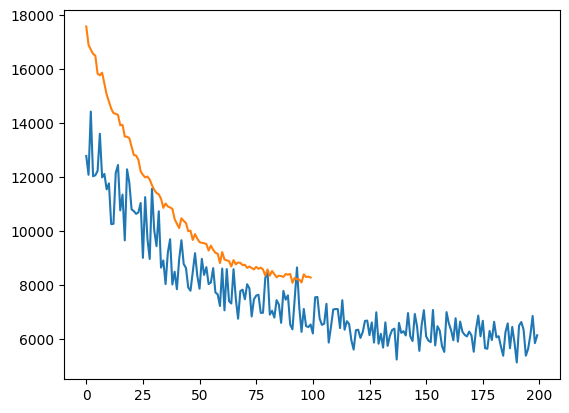

In [14]:
from matplotlib import pyplot as plt
losses = np.array(losses)
val_losses = np.array(val_losses)
fig, ax = plt.subplots()
ax.plot(losses)
ax.plot(val_losses)
plt.show()

In [15]:
def test(model,device,test_loader):
    histories = []
    predicts = []
    ground_truth=[]
    model.eval()
    mse = nn.MSELoss()
    
    
    with torch.no_grad():
        for i,(x,y) in enumerate(test_loader):
            model.eval()
            x = x.float().unsqueeze(dim=1).to(device)
            y = y.float().to(device)
            output = model(x).to(device).squeeze()
            loss = criterion(output,y)
            print('Test Loss:{:.4f}'.format(loss.item()))
            
            histories.append(x)
            predicts.append(output)
            ground_truth.append(y)
            
        return histories,predicts,ground_truth

In [17]:
histories,predicts,ground_truth = test(test_model,device,test_loader)

Test Loss:2566.5811
Test Loss:2507.0244
Test Loss:2531.5195
Test Loss:2580.0015


In [18]:
predicts[0].shape

torch.Size([256, 96])

In [19]:
ground_truth[0].shape

torch.Size([256, 96])

[ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]


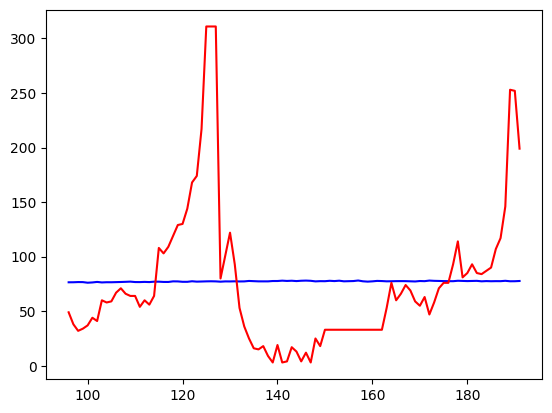

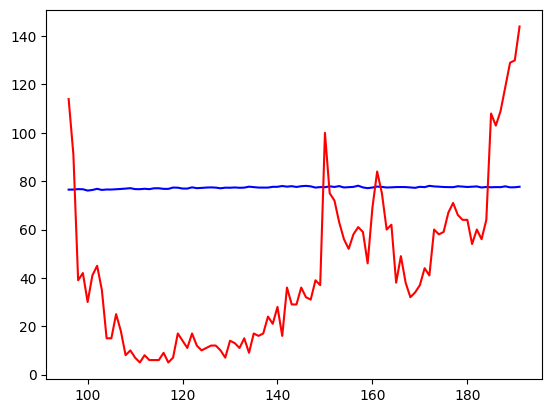

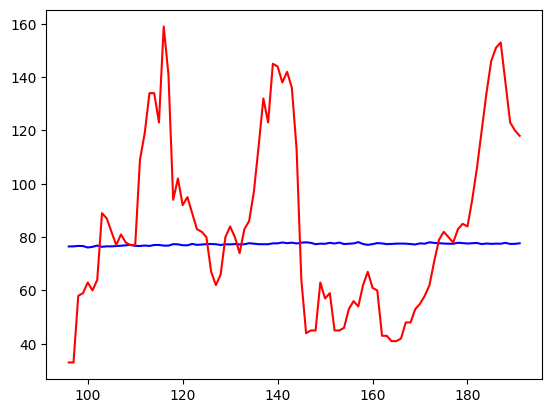

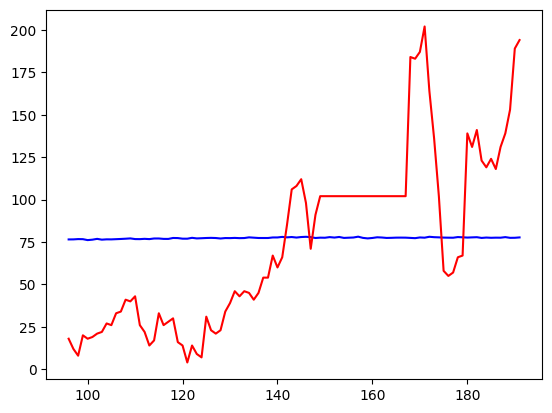

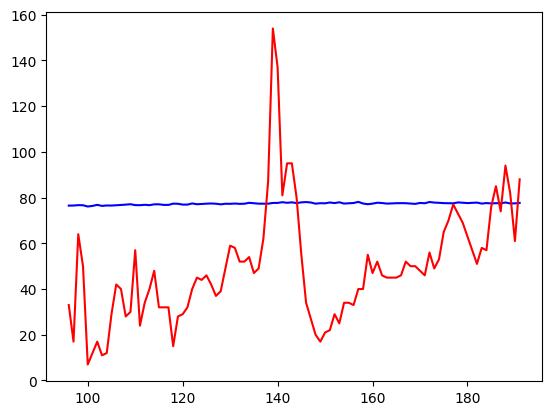

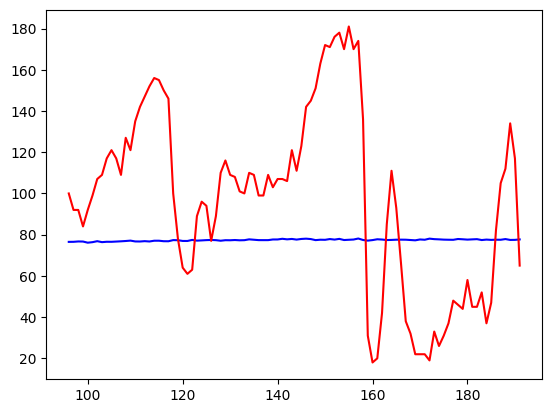

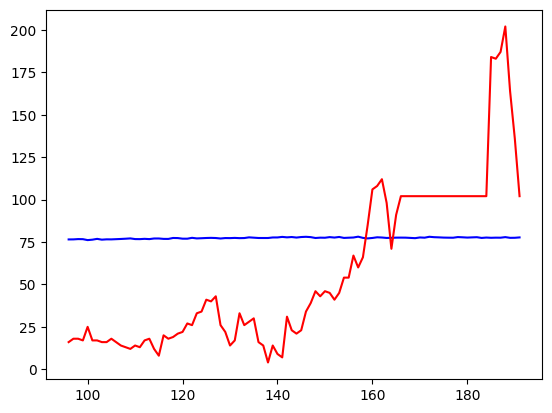

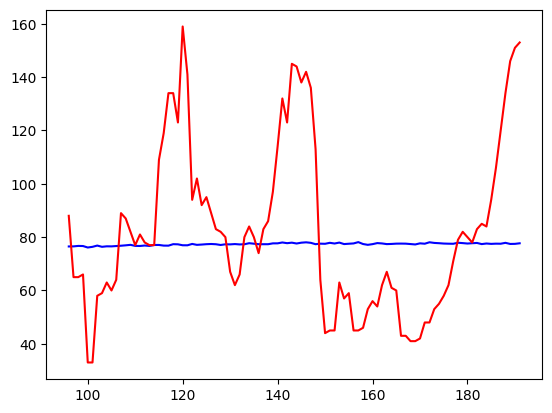

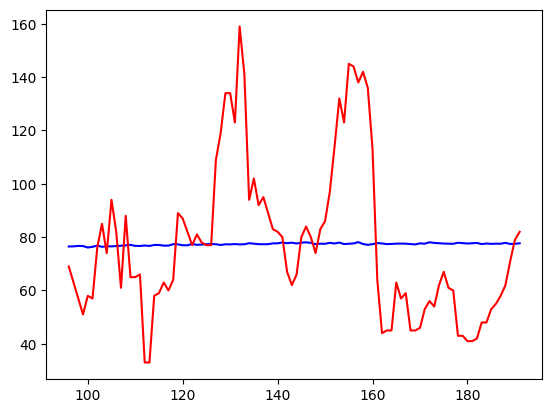

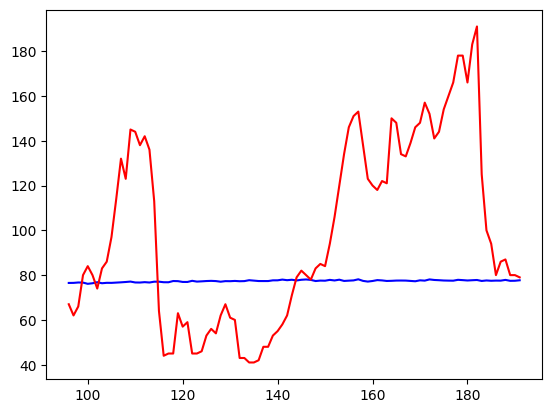

In [20]:

x1 = np.arange(histories[0].shape[2],histories[0].shape[2]+predicts[0].shape[1])
x2 = np.arange(histories[0].shape[2])
print(x1)
for i in range(10):
    y1 = predicts[0][i*10].cpu()
    y2 = ground_truth[0][i*10].cpu()
    y3 = histories[0][i,0,:].cpu()

    fig, ax = plt.subplots()
    ax.plot(x1, y1, label='predicts', color='blue')
    ax.plot(x1, y2, label='ground_truth', color='red')
    #ax.plot(x2,y3,label = 'histories',color='green')

    plt.show()